In [ ]:
pip install optuna xgboost pandas matplotlib numpy scipy seaborn scikit-learn imbalanced-learn lightgbm plotly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
import optuna
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, median_absolute_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import numpy as np
from scipy import stats
import plotly.express as px


In [ ]:
df= pd.read_csv('Sample - Superstore.csv', index_col = 'Row ID', encoding='cp1252')

In [ ]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Row ID,,,,,,,,,,,,,,,,,,,,
1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
num_rows, num_columns = df.shape

print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}\n")


Number of Rows: 9994
Number of Columns: 20



In [ ]:
# Creating a table for missing values, unique values and data types of the features

missing_values = pd.DataFrame({'Feature': df.columns,
                              'No. of Missing Values': df.isnull().sum().values,
                              '% of Missing Values': ((df.isnull().sum().values)/len(df)*100)})

unique_values = pd.DataFrame({'Feature': df.columns,
                              'No. of Unique Values': df.nunique().values})

feature_types = pd.DataFrame({'Feature': df.columns,
                              'DataType': df.dtypes})

merged_df = pd.merge(missing_values, unique_values, on='Feature', how='left')
merged_df = pd.merge(merged_df, feature_types, on='Feature', how='left')

merged_df

,Feature,No. of Missing Values,% of Missing Values,No. of Unique Values,DataType
0,Order ID,0,0.0,5009,object
1,Order Date,0,0.0,1237,object
2,Ship Date,0,0.0,1334,object
3,Ship Mode,0,0.0,4,object
4,Customer ID,0,0.0,793,object
5,Customer Name,0,0.0,793,object
6,Segment,0,0.0,3,object
7,Country,0,0.0,1,object
8,City,0,0.0,531,object
9,State,0,0.0,49,object


In [ ]:
# Count duplicate rows in train_data
duplicates = df.duplicated().sum()

# Print the results
print(f"Number of duplicate rows : {duplicates}")

Number of duplicate rows : 1


In [ ]:
# Having a look at the description of all the numerical columns present in the dataset

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Postal Code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.000,99301.000
Sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480
Quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000
Discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.200,0.800
Profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976


In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date']  = pd.to_datetime(df['Ship Date'])

In [ ]:
# Maximum value in the 'Order Date' column
max_order_date = df['Order Date'].max()

# Minimum value in the 'Order Date' column
min_order_date = df['Order Date'].min()

print("Maximum Order Date:", max_order_date)
print("Minimum Order Date:", min_order_date)

Maximum Order Date: 2017-12-30 00:00:00
Minimum Order Date: 2014-01-03 00:00:00


In [ ]:
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day

day_of_week_names = {
    0: 'Saturday',
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday'
}

df['Order Day of Week'] = df['Order Date'].dt.day_of_week.apply(lambda x: day_of_week_names[x])

In [ ]:
# Define the rank for each ship mode
ship_mode_rank = {
    'Same Day': 4,
    'First Class': 3,
    'Second Class': 2,
    'Standard Class': 1
}

# Create a new DataFrame to store the encoded ship modes
df_copy = df.copy()  # Copy the original DataFrame to avoid modifying it directly
df_copy['Encoded Ship Mode'] = df_copy['Ship Mode'].map(ship_mode_rank)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Group by Customer ID and aggregate sales-related metrics
customer_data = df_copy.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Discount': 'mean',
    'Profit': 'sum',
    'Encoded Ship Mode':  lambda x: x.mode().iloc[0]
}).reset_index()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.drop('Customer ID', axis=1))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

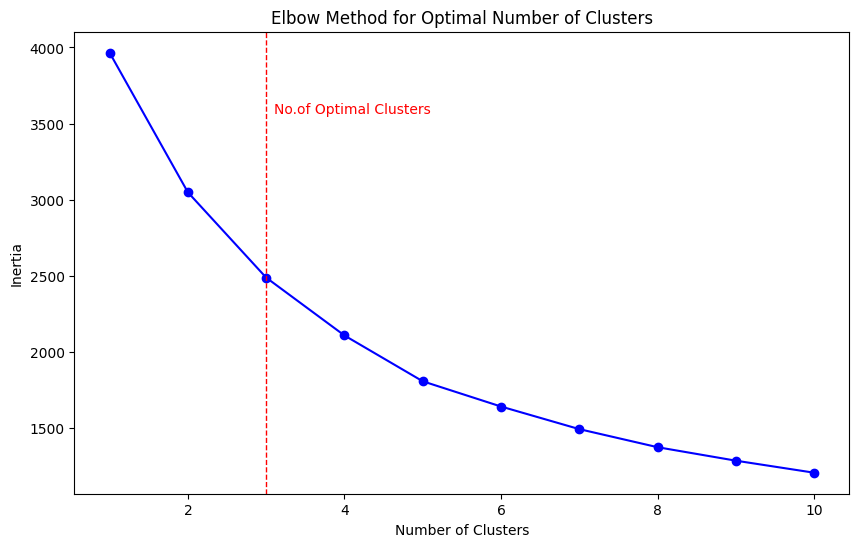

In [ ]:
# Elbow Method to determine the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')

# Marking the optimal number of clusters on the plot
optimal_clusters = 3  # Adjust this based on the elbow point
plt.axvline(x=optimal_clusters, color='red', linestyle='--', linewidth=1)
plt.text(optimal_clusters + 0.1, max(inertia) * 0.9, 'No.of Optimal Clusters', color='red', fontsize=10)

plt.show()

In [ ]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters as needed
kmeans.fit(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [ ]:
# Add cluster labels to the customer data
customer_data['Cluster'] = kmeans.labels_

In [ ]:
# You can also merge the cluster labels back to the original DataFrame to trace back each customer's cluster
df = pd.merge(df, customer_data[['Customer ID', 'Cluster']], on='Customer ID', how='left')

In [ ]:
def remove_outliers(df, columns):
    """
    Remove outliers from the DataFrame based on specified columns.

    Parameters:
        df (DataFrame): Input DataFrame.
        columns (list): List of columns to consider for outlier removal.

    Returns:
        DataFrame: DataFrame with outliers removed.
    """
    # Calculate the interquartile range (IQR) for each specified column
    Q1 = df[columns].quantile(0.10)
    Q3 = df[columns].quantile(0.90)
    IQR = Q3 - Q1

    # Define the upper and lower bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers from each specified column
    for col in columns:
        df = df[(df[col] >= lower_bound[col]) & (df[col] <= upper_bound[col])]

    return df

# Define columns to consider for outlier removal
columns_to_remove_outliers = ['Sales', 'Quantity', 'Discount', 'Profit']

# Apply the remove_outliers function to df and customer_data
df_cleaned = remove_outliers(df, columns_to_remove_outliers)
customer_data = remove_outliers(customer_data, columns_to_remove_outliers)


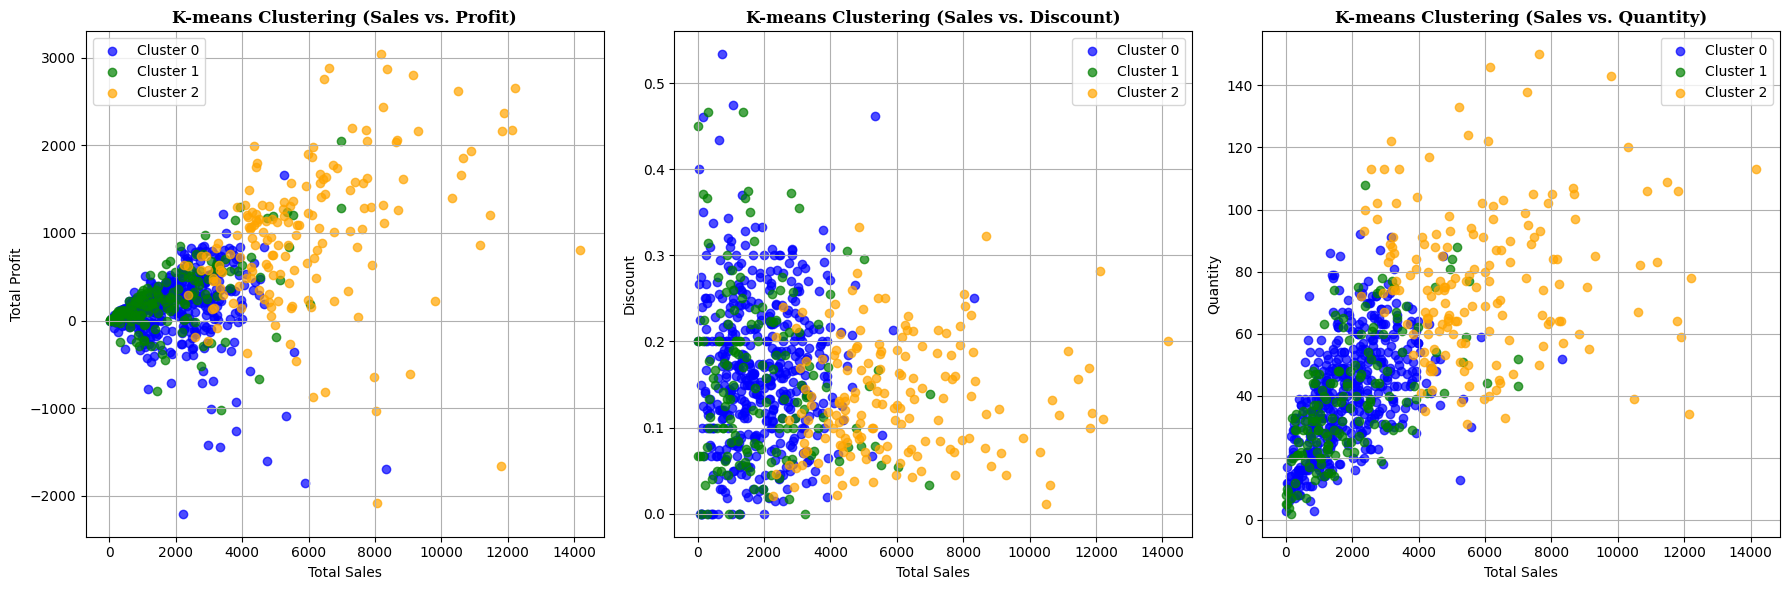

In [ ]:
import matplotlib.pyplot as plt

# Plotting the clusters
plt.figure(figsize=(18, 6))  # Adjust the figure size as needed
colors = ['blue', 'green', 'orange']  # Custom colors for clusters

# Sales vs. Profit plot
plt.subplot(1, 3, 1)
for cluster in range(customer_data['Cluster'].nunique()):
    cluster_data = customer_data[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Sales'], cluster_data['Profit'], label=f'Cluster {cluster}', color=colors[cluster], alpha=0.7)

plt.xlabel('Total Sales')
plt.ylabel('Total Profit')
plt.title('K-means Clustering (Sales vs. Profit)', fontweight='bold', fontfamily='serif')
plt.legend()
plt.grid(True)  # Add grid for a more professional look

# Sales vs. Discount plot
plt.subplot(1, 3, 2)
for cluster in range(customer_data['Cluster'].nunique()):
    cluster_data = customer_data[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Sales'], cluster_data['Discount'], label=f'Cluster {cluster}', color=colors[cluster], alpha=0.7)

plt.xlabel('Total Sales')
plt.ylabel('Discount')
plt.title('K-means Clustering (Sales vs. Discount)',fontweight='bold', fontfamily='serif')
plt.legend()
plt.grid(True)  # Add grid for a more professional look

# Sales vs. Quantity plot
plt.subplot(1, 3, 3)
for cluster in range(customer_data['Cluster'].nunique()):
    cluster_data = customer_data[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Sales'], cluster_data['Quantity'], label=f'Cluster {cluster}', color=colors[cluster], alpha=0.7)

plt.xlabel('Total Sales')
plt.ylabel('Quantity')
plt.title('K-means Clustering (Sales vs. Quantity)', fontweight='bold', fontfamily='serif')
plt.legend()
plt.grid(True)  # Add grid for a more professional look

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()


In [ ]:
import plotly.graph_objs as go

# Creating 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=customer_data['Sales'],
    y=customer_data['Quantity'],
    z=customer_data['Discount'],
    mode='markers',
    marker=dict(
        size=8,
        color=customer_data['Cluster'],  # Color points by cluster
        colorscale='Viridis',  # Choose a color scale
        opacity=0.8
    )
)])

# Setting layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Total Sales'),
        yaxis=dict(title='Quantity'),
        zaxis=dict(title='Discount'),
    ),
    title='Customer Segmentation by K-means Clustering (Sales, Quantity, and Discount)',
    margin=dict(l=0, r=0, b=0, t=30)  # Adjust margin to prevent overlap with title
)

# Show plot
fig.show()

<ipython-input-23-b86b2c2bd82b>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-23-b86b2c2bd82b>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-23-b86b2c2bd82b>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-23-b86b2c2bd82b>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




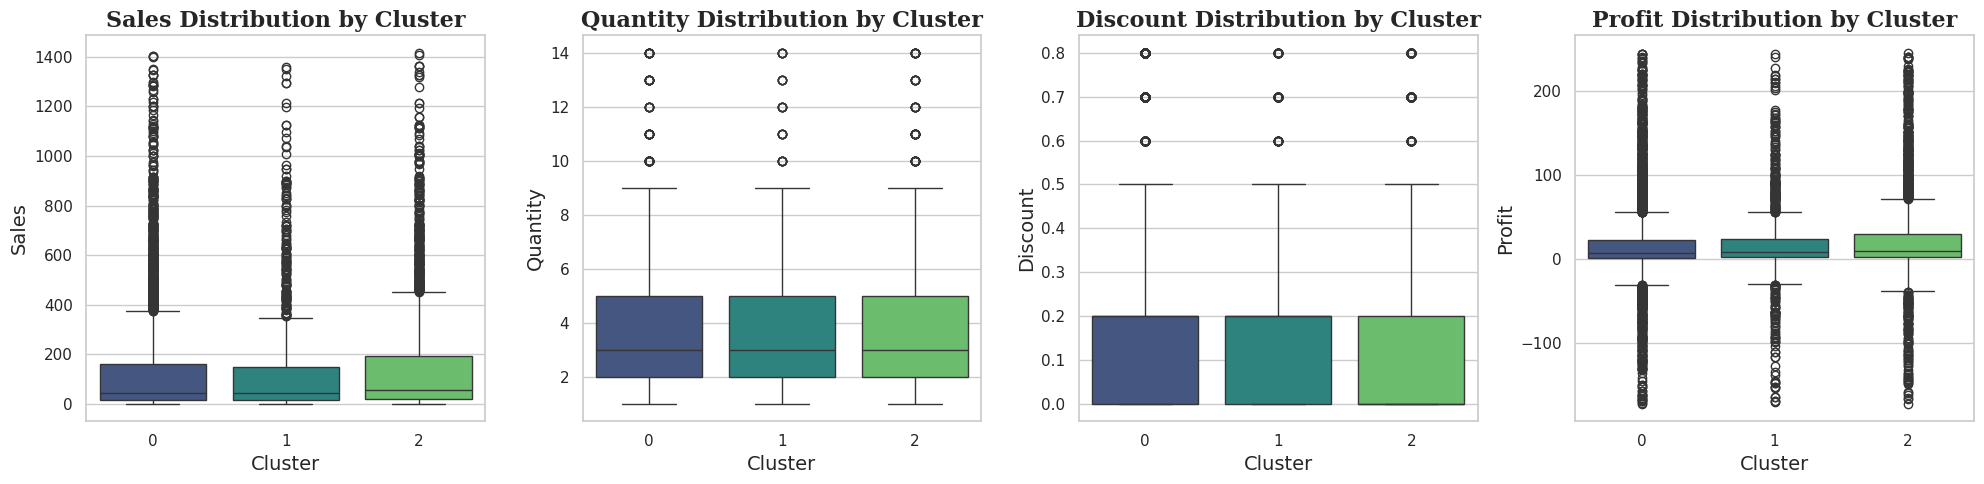

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid")

# Create box plots for each parameter in each cluster
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

params = ['Sales', 'Quantity', 'Discount', 'Profit']

for i, param in enumerate(params):
    sns.boxplot(x='Cluster', y=param, data=df_cleaned, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{param} Distribution by Cluster', fontsize=16, fontweight='bold', fontfamily='serif')
    axes[i].set_xlabel('Cluster', fontsize=14)
    axes[i].set_ylabel(param, fontsize=14)

plt.tight_layout()
plt.show()

<ipython-input-25-dc6ac926081e>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-25-dc6ac926081e>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-25-dc6ac926081e>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




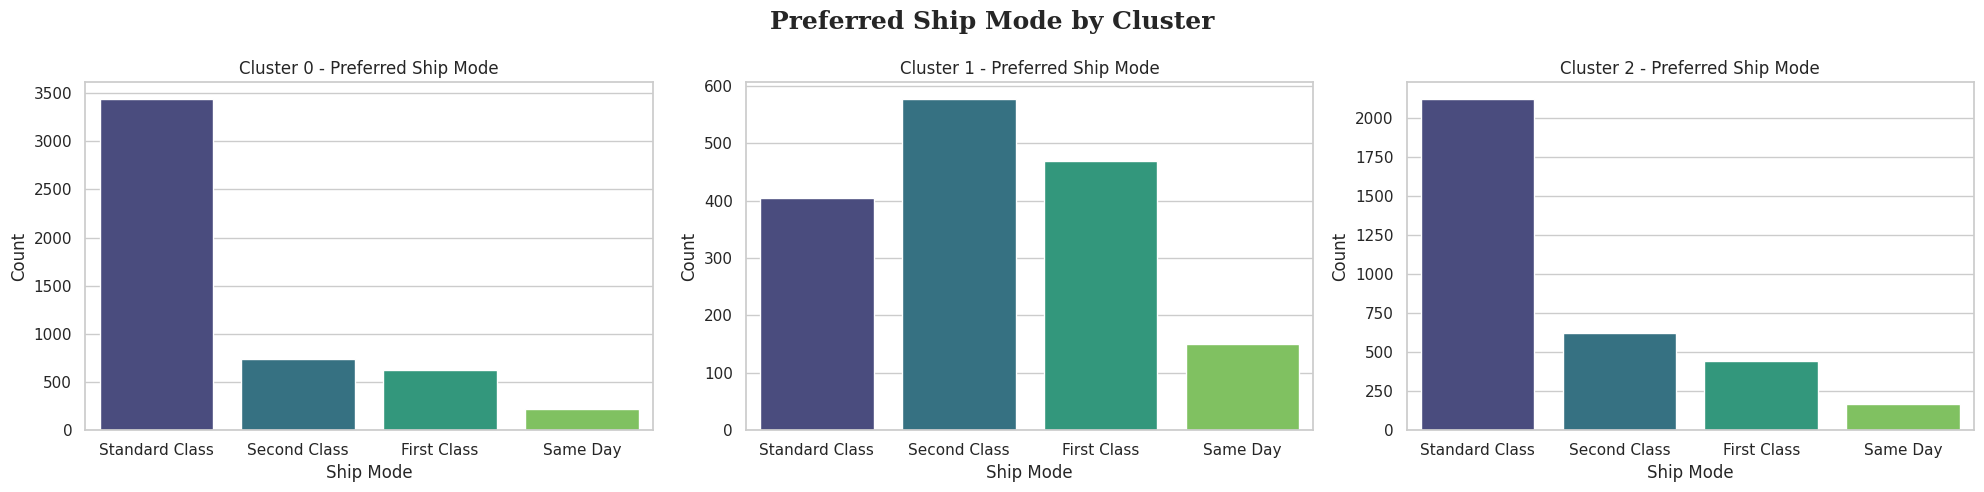

In [ ]:
# Get the ship mode order by frequency
ship_mode_order = df[df['Cluster'] == i]['Ship Mode'].value_counts().index

# Set the style
sns.set(style="whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 5))

# Loop through each cluster and create a plot
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.countplot(x='Ship Mode', data=df[df['Cluster'] == i], order=ship_mode_order,palette='viridis')
    plt.title(f'Cluster {i} - Preferred Ship Mode')
    plt.xlabel('Ship Mode')
    plt.ylabel('Count')

plt.suptitle('Preferred Ship Mode by Cluster', fontsize=18, fontweight='bold', fontfamily='serif')
plt.tight_layout()
plt.show()

<ipython-input-26-3aec5c4630fd>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-26-3aec5c4630fd>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-26-3aec5c4630fd>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




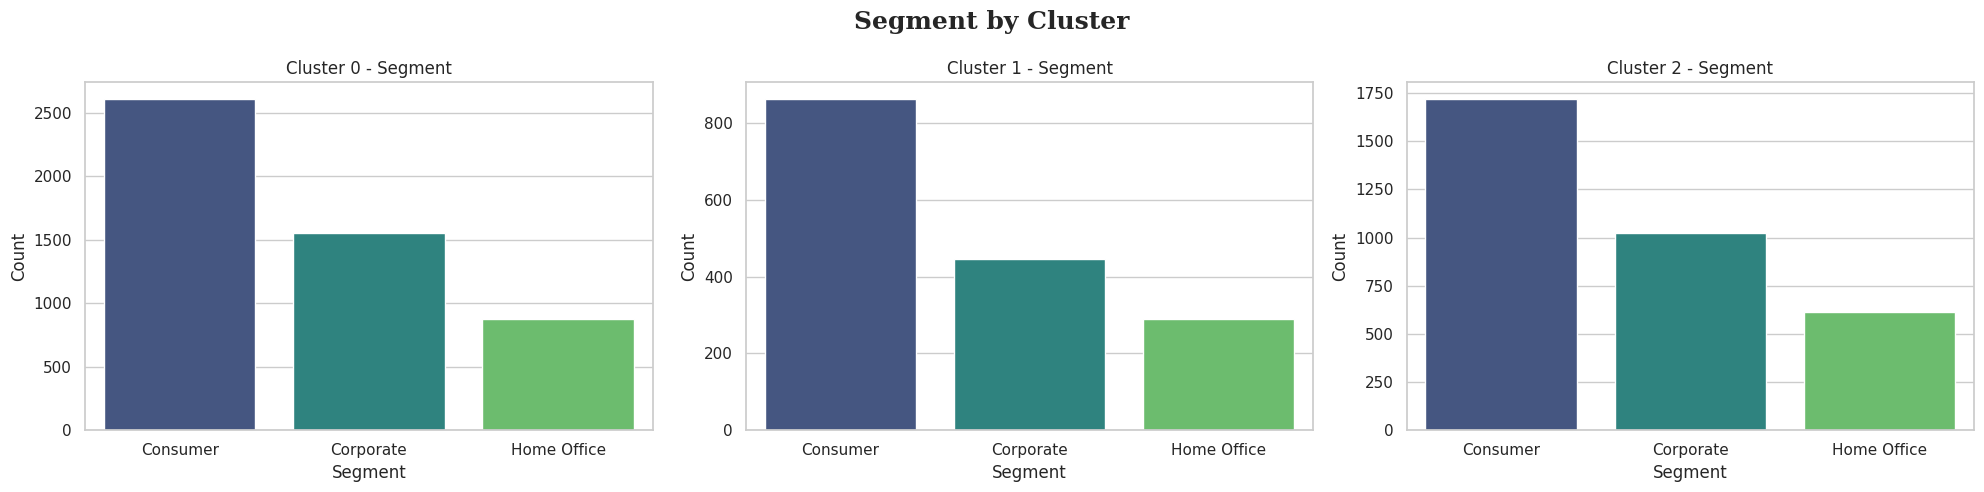

In [ ]:

# Get the segment order by frequency within each cluster
cluster_segment_order = {}
for i in range(3):
    cluster_segment_order[i] = df[df['Cluster'] == i]['Segment'].value_counts().index

# Set the style
sns.set(style="whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 5))

# Loop through each cluster and create a plot
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.countplot(x='Segment', data=df[df['Cluster'] == i], order=cluster_segment_order[i], palette='viridis')
    plt.title(f'Cluster {i} - Segment')
    plt.xlabel('Segment')
    plt.ylabel('Count')

plt.suptitle('Segment by Cluster', fontsize=18, fontweight='bold', fontfamily='serif')
plt.tight_layout()
plt.show()

<ipython-input-27-2414a04312ee>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-27-2414a04312ee>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-27-2414a04312ee>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




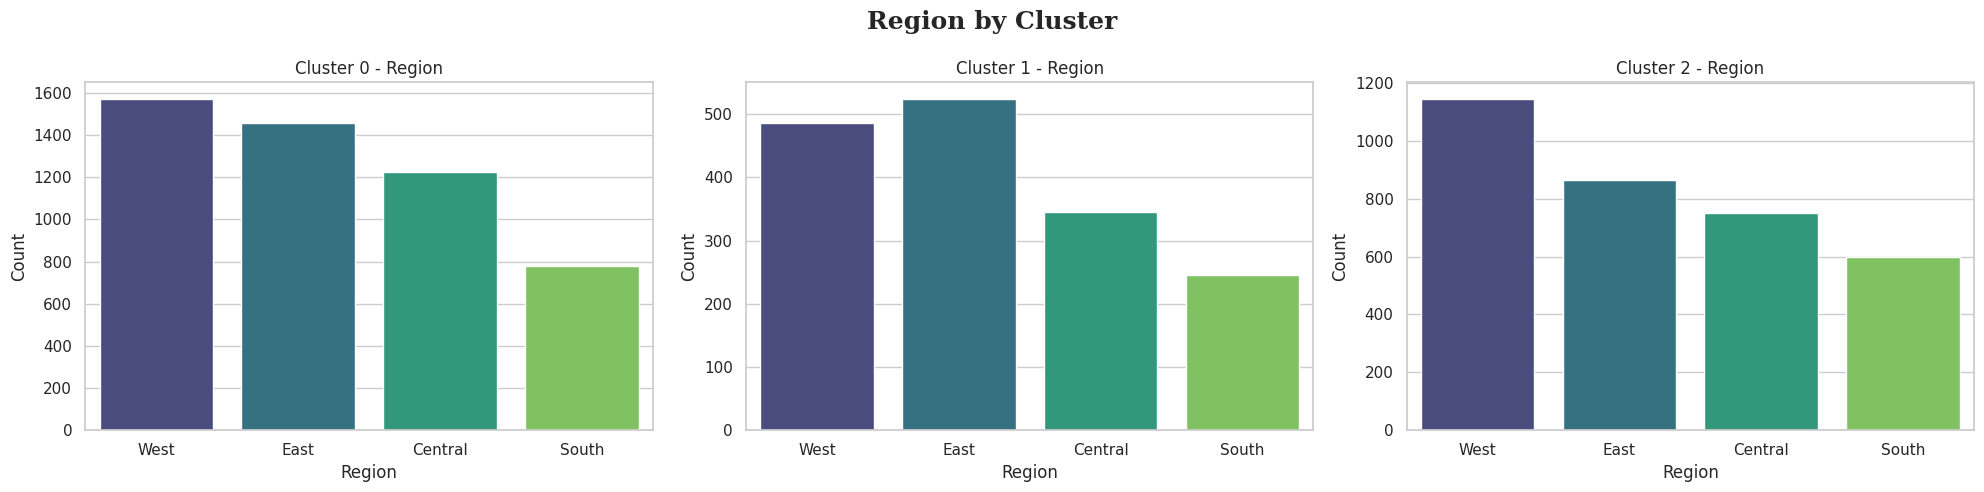

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the region order by frequency
region_order = df[df['Cluster'] == i]['Region'].value_counts().index

# Set the style
sns.set(style="whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 5))

# Loop through each cluster and create a plot
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.countplot(x='Region', data=df[df['Cluster'] == i], order=region_order, palette='viridis')
    plt.title(f'Cluster {i} - Region')
    plt.xlabel('Region')
    plt.ylabel('Count')

plt.suptitle('Region by Cluster', fontsize=18, fontweight='bold', fontfamily='serif')
plt.tight_layout()
plt.show()

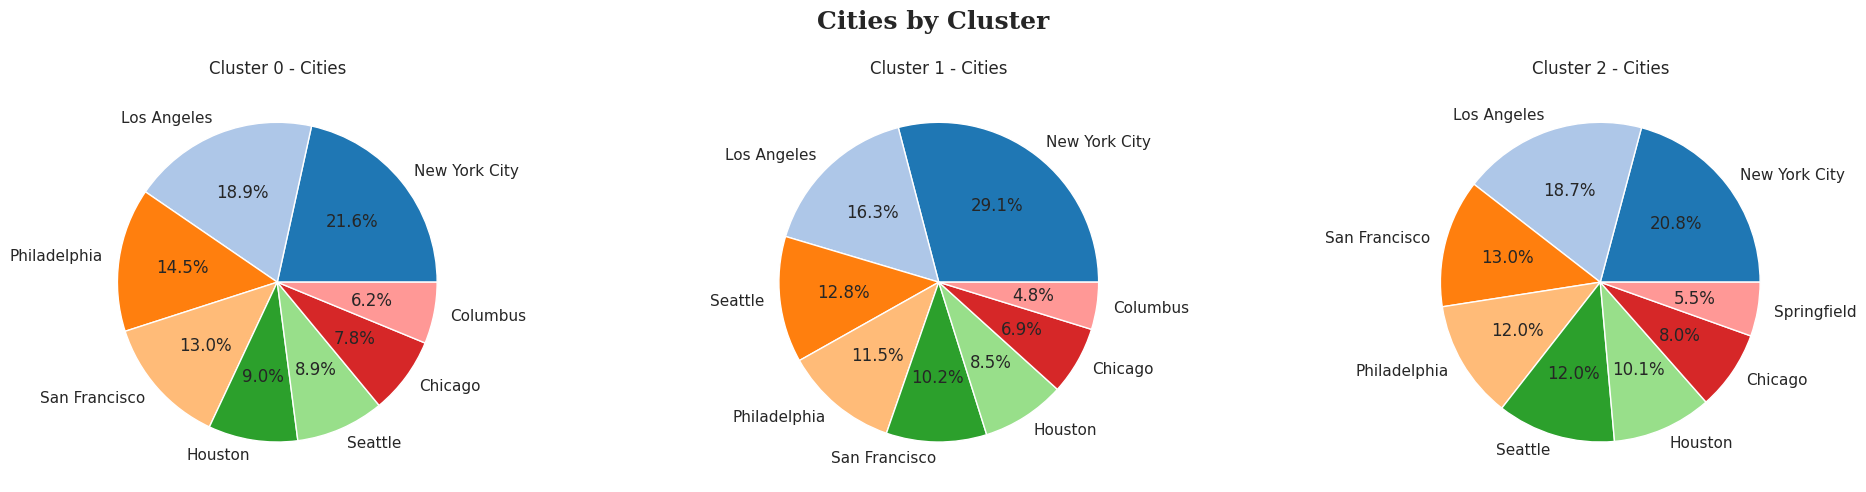

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 8 cities for each cluster
top_cities = df.groupby(['Cluster', 'City']).size().groupby('Cluster').nlargest(8).reset_index(level=0, drop=True).reset_index()

# Set the style
sns.set(style="whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 5))

# Loop through each cluster and create a pie chart
for i in range(3):
    plt.subplot(1, 3, i+1)
    top_cities_cluster = top_cities[top_cities['Cluster'] == i]
    plt.pie(top_cities_cluster[0], labels=top_cities_cluster['City'], autopct='%1.1f%%', colors=plt.cm.tab20.colors)
    plt.title(f'Cluster {i} - Cities')

plt.suptitle('Cities by Cluster', fontsize=18, fontweight='bold', fontfamily='serif')
plt.tight_layout()
plt.show()


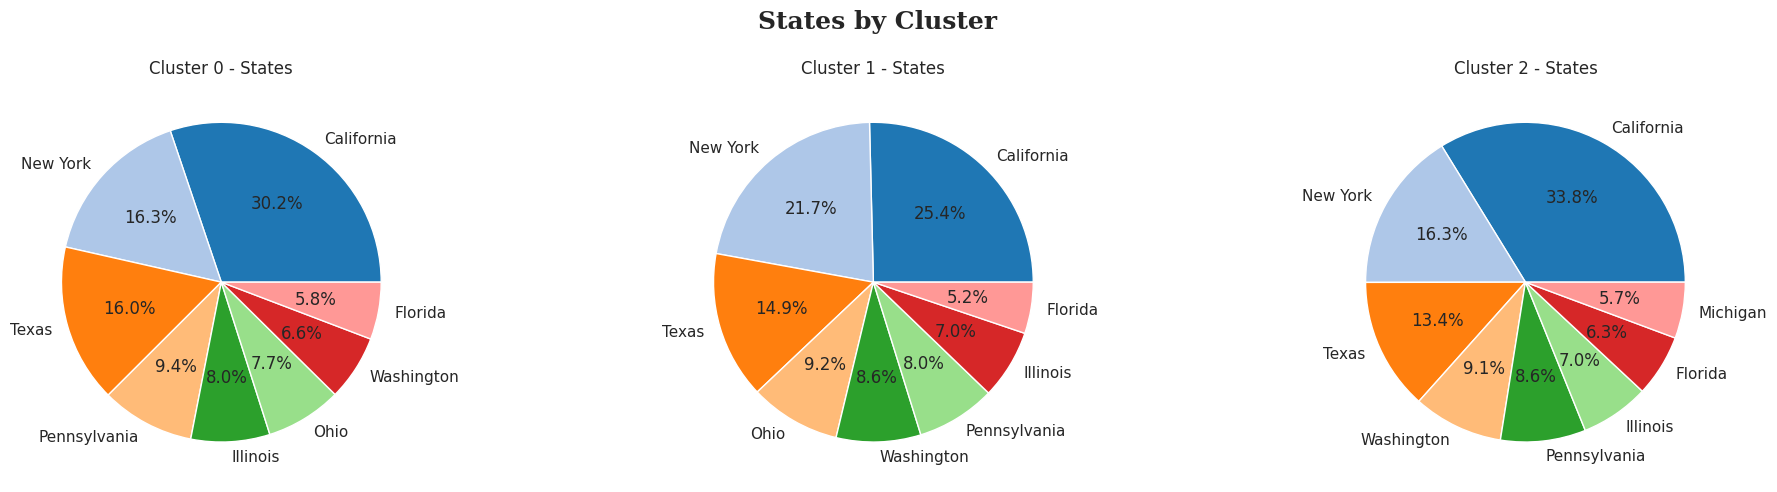

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 8 states for each cluster
top_states = df.groupby(['Cluster', 'State']).size().groupby('Cluster').nlargest(8).reset_index(level=0, drop=True).reset_index()

# Set the style
sns.set(style="whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 5))

# Loop through each cluster and create a pie chart
for i in range(3):
    plt.subplot(1, 3, i+1)
    top_states_cluster = top_states[top_states['Cluster'] == i]
    plt.pie(top_states_cluster[0], labels=top_states_cluster['State'], autopct='%1.1f%%', colors=plt.cm.tab20.colors)
    plt.title(f'Cluster {i} - States')

plt.suptitle('States by Cluster', fontsize=18, fontweight='bold', fontfamily='serif')
plt.tight_layout()
plt.show()

[link text](https://)



 📊💰 Sales Analysis




 What are the overall Sales & Profitability trends over time (daily, monthly, yearly)?

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('Sample - Superstore.csv', encoding='cp1252')

# Convert 'Order Date' and 'Ship Date' columns to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Extract relevant features for sales forecasting
features = ['Order Date', 'Ship Date', 'Quantity', 'Discount', 'Profit']

# Drop rows with missing values in selected features
df = df[features + ['Sales']].dropna()

# Define categorical features for one-hot encoding
categorical_features = ['Order Date', 'Ship Date']  # Assuming these are categorical for demonstration

# Create a ColumnTransformer for one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Split the data into training and testing sets
X = df.drop('Sales', axis=1)  # Features
y = df['Sales']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data (one-hot encoding)
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Initialize Decision Tree and Random Forest models
decision_tree = DecisionTreeRegressor(random_state=42)
random_forest = RandomForestRegressor(random_state=42)

# Train the models
decision_tree.fit(X_train_encoded, y_train)
random_forest.fit(X_train_encoded, y_train)

# Make predictions
y_pred_dt = decision_tree.predict(X_test_encoded)
y_pred_rf = random_forest.predict(X_test_encoded)

# Evaluate the models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Metrics:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R^2) Score: {r2}")
    print()

print("Decision Tree:")
evaluate_model(y_test, y_pred_dt, "Decision Tree")

print("Random Forest:")
evaluate_model(y_test, y_pred_rf, "Random Forest")


Decision Tree:
Decision Tree Metrics:
Mean Squared Error (MSE): 315000.9006338939
Mean Absolute Error (MAE): 115.68369399699849
R-squared (R^2) Score: 0.46673210245026364

Random Forest:
Random Forest Metrics:
Mean Squared Error (MSE): 303341.47322422813
Mean Absolute Error (MAE): 105.86829538519261
R-squared (R^2) Score: 0.4864704534482266



In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

# Define bins for categorizing sales values
sales_bins = [0, 100, 500, 1000, np.inf]
sales_labels = [0, 1, 2, 3]  # You can adjust labels as needed

# Bin the predicted sales values
y_pred_dt_binned = np.digitize(y_pred_dt, bins=sales_bins, right=True)
y_pred_rf_binned = np.digitize(y_pred_rf, bins=sales_bins, right=True)

# Convert true sales values to binned categories
y_test_binned = np.digitize(y_test, bins=sales_bins, right=True)

# Calculate metrics for Decision Tree
print("Decision Tree:")
print("F1 Score:", f1_score(y_test_binned, y_pred_dt_binned, average='weighted'))
print("Accuracy:", accuracy_score(y_test_binned, y_pred_dt_binned))
print("Recall:", recall_score(y_test_binned, y_pred_dt_binned, average='weighted'))
print("Precision:", precision_score(y_test_binned, y_pred_dt_binned, average='weighted'))
print()

# Calculate metrics for Random Forest
print("Random Forest:")
print("F1 Score:", f1_score(y_test_binned, y_pred_rf_binned, average='weighted'))
print("Accuracy:", accuracy_score(y_test_binned, y_pred_rf_binned))
print("Recall:", recall_score(y_test_binned, y_pred_rf_binned, average='weighted'))
print("Precision:", precision_score(y_test_binned, y_pred_rf_binned, average='weighted'))


Decision Tree:
F1 Score: 0.8189143166335969
Accuracy: 0.8269134567283641
Recall: 0.8269134567283641
Precision: 0.8160143361658085

Random Forest:
F1 Score: 0.8248088113906656
Accuracy: 0.8279139569784892
Recall: 0.8279139569784892
Precision: 0.8231856505404282
